# Machine Learning (Top 10)

## Libraries

* we will be using Tensorflow 2.0, which is not installed by default on Google Colab, so we will pip install it
  * this will take a couple of seconds, wait for the cell to finish running
* after this, we will import all the libraries we will be using for our machine learning model

In [0]:
%%capture
!pip install tensorflow==2.0.0-alpha0

In [0]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

print(tf.__version__)

2.0.0-alpha0


## Installing the Dataset

* the fastest way to access the dog dataset is to in Google Colab  is to directly 
  * we have attempted to use Google drive, but this is significantly slower to access then directly adding the data to session
  * tensors can also be preprocessed on another machine and loaded as pickle files as well
* if you would like to download the kaggle dataset yourself, follow the following steps:
  1. Create a Kaggle Account
  2. Enter into the [Dog Breed Kaggle Competition](https://www.kaggle.com/c/dog-breed-identification)
  3. Go to My Account > Create New API Token
  4. Download the JSON file and store it in the home directory of this notebook
  5. Run the code cell below (this will take a minute)


In [0]:
%%capture
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!kaggle competitions download -c dog-breed-identification
!unzip labels.csv
!unzip train
!unzip test

In [0]:
base_path = ''
train_path = base_path + 'train/'
test_path = base_path + 'test/'
csv_path = base_path + 'labels.csv'

In [0]:
# get the labels
train_csv = pd.read_csv(csv_path)

print(train_csv.describe())
print()
train_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     b39c3d11e16d3432246aceac3e4ab3fe  scottish_deerhound
freq                                   1                 126



,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Data Selection

We will explore three options of data sources:

1. the entire dataset 
  * advatages: there's a lot of data (10,000 images)
  * disadvantages: too many labels (120 breeds)
2. top-n breeds
  * advantages: limits the amount of labels 
  * disadvantages: reduces the data (because approx equal distribution of data accross each breed in the dataset)
3. similar breed groups (terriers, hounds, etc.)
  * advantages: limits labels while keeping breed count high
  * disadvantages: grouping dogs is subjective (we are only grouping by similar keywords, the dogs with the same breed keyword may be very different)



### 1. The Entire Dataset

In [0]:
unique_breeds = train_csv.breed.unique()

breeds = {unique_breeds[i]: i for i in range(len(unique_breeds))} 

In [0]:

fnames = [train_path + fname + '.jpg' for fname in train_csv['id'].tolist()]
labels = [breeds[s] for s in train_csv['breed'].tolist()]

train_fnames, test_fnames, train_labels, test_labels = train_test_split(fnames,
                                                                        labels,
                                                                        train_size=0.9,
                                                                        random_state=420)

num_train = len(train_fnames)
num_test = len(test_fnames)

### 2. The Top-N Breeds

In [0]:
def top_n(n, labels, train_path):

  # Get the top-n breeds as a list of strings
  breed_counts = train_csv.breed.value_counts()
  top_n_breeds = breed_counts[0:n].keys().to_list()

  # Make a table of only the top-n breeds
  top_n_labels = labels[labels.breed.isin(top_n_breeds)]

  # Create a breeds dictionary
  unique_breeds = top_n_labels.breed.unique()
  breeds = {unique_breeds[i]: i for i in range(len(unique_breeds))} 

  # create fnames and labels
  fnames = [train_path + fname + '.jpg' for fname in top_n_labels['id'].tolist()]
  labels = [breeds[s] for s in top_n_labels['breed'].tolist()]

  # split training and test dataset
  train_fnames, test_fnames, train_labels, test_labels = train_test_split(fnames,
                                                                        labels,
                                                                        train_size=0.9,
                                                                        random_state=420)
  
  # Lengths of our train / test
  num_train = len(train_fnames)
  num_test = len(test_fnames)

  return breeds, train_fnames, test_fnames, train_labels, test_labels, num_train, num_test

In [0]:
breeds, train_fnames, test_fnames, train_labels, test_labels, num_train, num_test = top_n(10, train_csv, train_path)

In [0]:
num_train

1026

### 3. Similar Breed Groups


## Parsing the Data

* IMAGE_SIZE determines the height and width of the image in pixels

### parse_fn
1. **read_file**: creates a tensor string about a file (given the path)
2. **decode_jpeg**: creates tensor array of the image (RGB values 0-255)
3. convert *int* to *float*, standardize the values to ± 1.0
4. Resize the image to 96 x 96 image
  * this stretches the image down to the 96 x 96 resolution, not crop

Areas to improve:
* crop iamges at appropriate places
* possibly generate more data with rotations


In [0]:
image_decoded = tf.image.decode_jpeg(tf.io.read_file(fnames[0]))
image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))

print(image_normalized.shape, '\n', image_resized.shape)

(375, 500, 3) 
 (96, 96, 3)


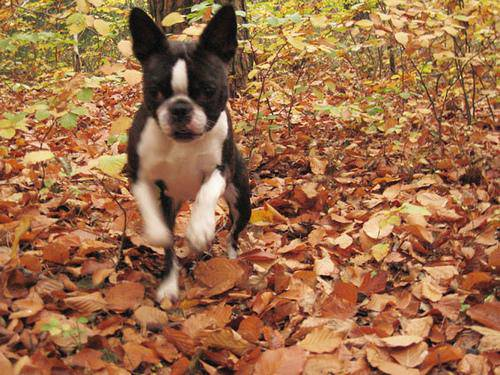

In [0]:
from IPython.display import Image
Image(filename=fnames[0]) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


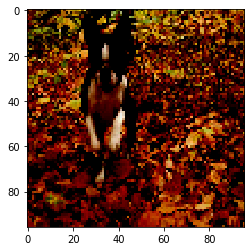

In [0]:
import matplotlib.pyplot as plt
plt.imshow(image_resized)

In [0]:
IMAGE_SIZE = 96

def parse_fn(filename, label):
  image_string = tf.io.read_file(filename) # 1
  image_decoded = tf.image.decode_jpeg(image_string) #2
  image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1 #3
  image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE)) #4
  return image_resized, label

### Creating our Training / Validation Data

* Goal: create a PrefetchDataset object for training and validation data
  * this reduces overall [processing time](https://www.tensorflow.org/guide/data_performance)
* tf.constant() just makes arrays tensor types
* to adjust what data is given, just change fnames and labels size


In [0]:
BATCH_SIZE = 32

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_fnames), tf.constant(train_labels))).map(parse_fn).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_fnames), tf.constant(test_labels))).map(parse_fn).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

## Creating our Model

Questions to Ask:
* why are we using MobileNet?
* how can we add layers to improve our model?

In [0]:
# Base model with MobileNetV2
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False

In [0]:

# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(len(breeds), activation='softmax')

In [0]:
learning_rate = 0.0001

model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
num_epochs = 20
steps_per_epoch = round(num_train)//BATCH_SIZE
val_steps = 20

In [0]:
history = model.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps)

Epoch 1/20
32/32 [==============================] - 37s 1s/step - loss: 4.5418 - accuracy: 0.1084 - val_loss: 4.0266 - val_accuracy: 0.1130
Epoch 2/20
32/32 [==============================] - 34s 1s/step - loss: 3.7029 - accuracy: 0.1579 - val_loss: 3.3981 - val_accuracy: 0.1565
Epoch 3/20
32/32 [==============================] - 34s 1s/step - loss: 3.0306 - accuracy: 0.2324 - val_loss: 2.8666 - val_accuracy: 0.2348
Epoch 4/20
32/32 [==============================] - 34s 1s/step - loss: 2.7677 - accuracy: 0.3028 - val_loss: 2.4307 - val_accuracy: 0.3043
Epoch 5/20
32/32 [==============================] - 33s 1s/step - loss: 2.2840 - accuracy: 0.3481 - val_loss: 2.1308 - val_accuracy: 0.3913
Epoch 6/20
32/32 [==============================] - 33s 1s/step - loss: 2.2144 - accuracy: 0.3873 - val_loss: 1.8700 - val_accuracy: 0.4696
Epoch 7/20
32/32 [==============================] - 33s 1s/step - loss: 1.7541 - accuracy: 0.4648 - val_loss: 1.6493 - val_accuracy: 0.5043
Epoch 8/20
32/32 [==

### Save the model

Once the model is run, the model architecture and associated weights can be stored in hdf5 file.

In [0]:
from keras.models import load_model

model.save('top_10_dog_breeds.hdf5')

# save the history data for graphing
pd.DataFrame(history.history).to_csv("top_10_dog_history.csv")

## Analysis


### Running Our Model

In [0]:
# Load hdf5 here

# Make a prediction on one of our images

### Graphing Our Results

In [0]:
history_df = pd.read_csv("top_10_dog_history.csv")

In [0]:
history_df.head()

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,4.541831,0.108398,4.026620,0.113043
1,1,3.675129,0.157948,3.398122,0.156522
2,2,3.044693,0.232394,2.866640,0.234783
3,3,2.680835,0.302817,2.430703,0.304348
4,4,2.304596,0.348089,2.130817,0.391304


Text(0.5, 1.0, 'Accuracy')

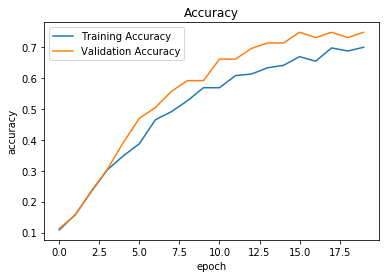

In [0]:
import matplotlib.pyplot as plt

plt.plot(history_df.accuracy, label='Training Accuracy')
plt.plot(history_df.val_accuracy, label='Validation Accuracy')

plt.legend()

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")

Text(0.5, 1.0, 'Loss')

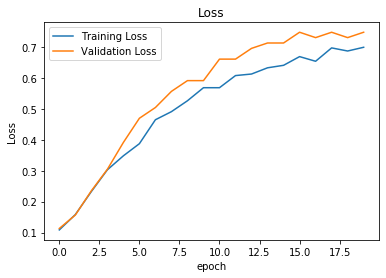

In [0]:
import matplotlib.pyplot as plt

plt.plot(history_df.accuracy, label='Training Loss')
plt.plot(history_df.val_accuracy, label='Validation Loss')

plt.legend()

plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title("Loss")